# Index
[1. Exploratory Data Analysis](#10)  
&nbsp;&nbsp;[1.1 Correlation between features](#11)  
&nbsp;&nbsp;[1.2 Goals](#12)  
&nbsp;&nbsp;[1.3 Disposals](#13)  
&nbsp;&nbsp;[1.4 Contested posession](#24)  
&nbsp;&nbsp;[1.5 Uncontested possession](#25)  
&nbsp;&nbsp;[1.6 Home Court Advantage](#16) 

[2. Feature Engineering](#20)  
&nbsp;&nbsp;[2.1 Time block number](#21)  
&nbsp;&nbsp;[2.2 Match ID](#22)  
&nbsp;&nbsp;[2.3 Ratio of Statistics](#23)  
&nbsp;&nbsp;[2.4 Scorer](#24)   
&nbsp;&nbsp;[2.5 Passer](#25)  
&nbsp;&nbsp;[2.6 Contested Possession](#26)  
&nbsp;&nbsp;[2.7 Uncontested Possession](#27)  
&nbsp;&nbsp;[2.8 Past Season Brownlow Votes](#28)  
&nbsp;&nbsp;[2.9 Lag Features](#29)  
&nbsp;&nbsp;[2.10 Team Performance](#210) 


[3. Final Clean Up](#30)   

[4. Modelling](#40)  
&nbsp;&nbsp;[4.1 Baseline](#41)  
&nbsp;&nbsp;[4.2 Base Model](#42)  
&nbsp;&nbsp;&nbsp;[4.2.1 Gradient Boosted Decision Tree](#421)  
&nbsp;&nbsp;&nbsp;[4.2.2 Neural Network](#422)  
&nbsp;&nbsp;[4.3 Ensembling](#43)

[5. Normalising prediction for test set and predict for Brownlow medal winner](#50)  
[6. Conclusion](#60)  

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [2]:
# Load data
df = pd.read_csv('RawData.csv')
df.head()

,Date,Name,Team,Season,Round,Home Team,Away Team,Home Score,Away Score,Margin,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,Brownlow Votes,TOG
0,2019-09-28 00:00:00,Zac Williams,Greater Western Sydney,2019.0,GF,Richmond,Greater Western Sydney,114,25,89,21.0,11.0,4.0,10.0,0.0,0.0,0.0,5.0,1.0,3.0,3.0,4.0,0.0,0.0,7.0,13.0,0.0,1.0,0.0,0.0,0.0,68
1,2019-09-28 00:00:00,Lachie Whitfield,Greater Western Sydney,2019.0,GF,Richmond,Greater Western Sydney,114,25,89,14.0,12.0,3.0,2.0,0.0,0.0,0.0,1.0,5.0,2.0,3.0,3.0,0.0,1.0,4.0,9.0,0.0,0.0,1.0,0.0,0.0,91
2,2019-09-28 00:00:00,Adam Tomlinson,Greater Western Sydney,2019.0,GF,Richmond,Greater Western Sydney,114,25,89,17.0,11.0,6.0,6.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,3.0,0.0,1.0,6.0,11.0,0.0,0.0,1.0,0.0,0.0,83
3,2019-09-28 00:00:00,Sam Taylor,Greater Western Sydney,2019.0,GF,Richmond,Greater Western Sydney,114,25,89,14.0,6.0,4.0,8.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,1.0,0.0,6.0,8.0,1.0,0.0,9.0,0.0,0.0,91
4,2019-09-28 00:00:00,Tim Taranto,Greater Western Sydney,2019.0,GF,Richmond,Greater Western Sydney,114,25,89,30.0,14.0,5.0,16.0,0.0,0.0,0.0,7.0,3.0,4.0,5.0,4.0,3.0,1.0,15.0,18.0,0.0,0.0,1.0,0.0,0.0,80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146607 entries, 0 to 146606
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date             146607 non-null  object 
 1   Name             146607 non-null  object 
 2   Team             146607 non-null  object 
 3   Season           146607 non-null  float64
 4   Round            146607 non-null  object 
 5   Home Team        146607 non-null  object 
 6   Away Team        146607 non-null  object 
 7   Home Score       146607 non-null  int64  
 8   Away Score       146607 non-null  int64  
 9   Margin           146607 non-null  int64  
 10  Disposals        146607 non-null  float64
 11  Kicks            146607 non-null  float64
 12  Marks            146607 non-null  float64
 13  Handballs        146607 non-null  float64
 14  Goals            146607 non-null  float64
 15  Behinds          146607 non-null  float64
 16  Hitouts          146607 non-null  floa

There are no missing values in the dataset.

The data consist of all matches, however, there are no Brownlow votes in the playoffs. Therefore, all the non-regular season games will be filtered out.

In [4]:
df = df[df.Round.str.isdigit()]

In [5]:
# change datatype in Round column to int
df['Round'] = df['Round'].astype('int')

# 1. Exploratory Data Analysis<a id="10"></a>

Before generating features and building model, it is important to know which statistics / factors are more likely to result in a Brownlow vote.

## 1.1 Correlation between features<a id="11"></a>

In [6]:
# correlation between statistics
temp = df.iloc[:,10:]
corr = temp.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,Brownlow Votes,TOG
Disposals,1.000000,0.823010,0.437695,0.786788,0.041529,0.071099,-0.130473,0.271219,0.351442,0.506018,0.527111,0.294808,0.202481,0.036664,0.665499,0.873999,-0.008757,-0.021318,-0.051372,0.197566,0.362263,0.334436
Kicks,0.823010,1.000000,0.552535,0.296935,0.161635,0.169576,-0.172577,0.152836,0.418479,0.552589,0.337520,0.275529,0.190485,0.010257,0.446892,0.762614,0.074850,0.102021,-0.035083,0.188843,0.336779,0.353753
Marks,0.437695,0.552535,1.000000,0.135411,0.189962,0.144656,-0.068686,-0.091521,0.243816,0.188574,-0.075815,0.078031,0.006283,-0.009849,0.067303,0.538763,0.366333,0.324698,0.088147,0.104349,0.189764,0.326878
Handballs,0.786788,0.296935,0.135411,1.000000,-0.105821,-0.064739,-0.031811,0.289868,0.136077,0.250206,0.519364,0.196203,0.133403,0.050489,0.633159,0.640597,-0.096054,-0.146695,-0.048239,0.126926,0.243046,0.177822
Goals,0.041529,0.161635,0.189962,-0.105821,1.000000,0.327699,-0.027869,-0.016868,-0.244592,0.164366,-0.011588,0.024117,0.107803,0.024465,0.113185,-0.011848,0.286204,0.685889,-0.179243,0.166275,0.269141,0.124441
Behinds,0.071099,0.169576,0.144656,-0.064739,0.327699,1.000000,-0.029894,0.006920,-0.199406,0.197438,0.024188,0.034356,0.088969,0.018916,0.117563,0.023330,0.196053,0.526987,-0.163232,0.144761,0.114491,0.093770
Hitouts,-0.130473,-0.172577,-0.068686,-0.031811,-0.027869,-0.029894,1.000000,-0.001873,-0.112741,-0.061703,0.134761,0.030041,0.115716,0.116300,0.049249,-0.197244,0.133149,0.001225,0.056641,-0.027351,0.007008,-0.050599
Tackles,0.271219,0.152836,-0.091521,0.289868,-0.016868,0.006920,-0.001873,1.000000,-0.025953,0.195433,0.369023,0.146987,0.199700,0.095009,0.354142,0.138024,-0.098446,-0.072398,-0.077341,0.074583,0.114096,0.083374
Rebounds,0.351442,0.418479,0.243816,0.136077,-0.244592,-0.199406,-0.112741,-0.025953,1.000000,-0.055658,-0.009135,0.091907,0.001798,-0.022033,0.075754,0.364597,-0.030048,-0.256338,0.282944,-0.112170,0.047375,0.259177
Inside 50s,0.506018,0.552589,0.188574,0.250206,0.164366,0.197438,-0.061703,0.195433,-0.055658,1.000000,0.374626,0.198457,0.148034,0.035410,0.368807,0.434397,-0.008665,0.074922,-0.207567,0.329030,0.251191,0.114306


The statistics that seem to have significant correlation with Brownlow votes include
- Disposals
- Kicks
- Goals
- Clearences
- Contested PO
- Uncontested PO

Goal is self explanatory. Contested and Uncontested PO mean the ability to help the team to gain possession. Disposals and kicks mean passing the ball, which can also be thought of the number of time a player has been in possession of the ball. This makes sense since the superstar of the team is more likely to be involved in a set play. 

Now, let's examine what is the difference between the average player's Brownlow vote with player who is a good scorer and player who has more possessions.

## 1.2 Goals <a id="12"></a>

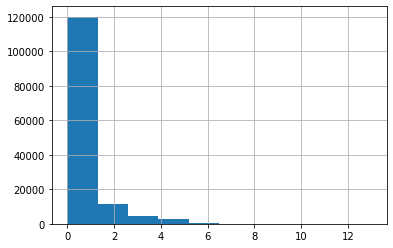

In [7]:
df.Goals.hist()

In [8]:
# all player average
goals_blv = pd.DataFrame(df.groupby('Season')['Brownlow Votes'].mean()).reset_index()
goals_blv.columns = ['Season', 'Average']
goals_blv.head()

,Season,Average
0,2003.0,0.136381
1,2004.0,0.136364
2,2005.0,0.136364
3,2006.0,0.136364
4,2007.0,0.136364


In [9]:
# goal & BLV historical relationships
for i in range(2,10):
    col_name = str(i)+'+goals'
    goals_blv[col_name] = df.query('Goals >= '+str(i)).groupby('Season')['Brownlow Votes'].mean().values
goals_blv

,Season,Average,2+goals,3+goals,4+goals,5+goals,6+goals,7+goals,8+goals,9+goals
0,2003.0,0.136381,0.372940,0.554688,0.872549,1.263158,1.918919,2.428571,2.400000,3.000000
1,2004.0,0.136364,0.380952,0.536534,0.827103,1.245098,1.672727,2.111111,2.333333,2.142857
2,2005.0,0.136364,0.393170,0.645545,0.916000,1.313559,1.720930,2.294118,2.555556,2.666667
3,2006.0,0.136364,0.414390,0.657328,1.106280,1.505263,2.102041,2.541667,2.666667,3.000000
4,2007.0,0.136364,0.330716,0.497196,0.751111,1.094118,1.647059,2.615385,3.000000,3.000000
5,2008.0,0.136364,0.386874,0.602273,0.944444,1.482143,1.942308,2.190476,2.666667,3.000000
6,2009.0,0.136364,0.353636,0.570499,0.863636,1.338235,1.590909,2.125000,2.000000,2.000000
7,2010.0,0.136364,0.377859,0.609244,0.954545,1.420455,2.038462,2.444444,3.000000,3.000000
8,2011.0,0.136364,0.378335,0.569915,0.978495,1.323944,1.827586,2.555556,2.666667,3.000000
9,2012.0,0.136364,0.397525,0.593385,0.915344,1.413333,2.520000,2.900000,3.000000,3.000000


- From the summary, it can be seen that when player score 5+ goals, he is very likely to attract a Brownlow Vote (the average for all seasons are greater than 1). 
- When a player performs extremely well in the offensive end, score 8+ goal, he is almost certain to receive 3 Brownlow votes.
- It is also worth noting that, there is an increasing emphasis on offensive talent as the league evolved. Score 5+ goal can on average attract 1.2 Brownlow vote in 2003, but 1.625 Brownlow vote in 2019.

## 1.3 Disposals <a id="13"></a>

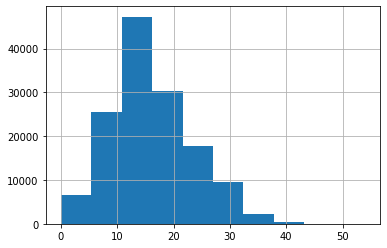

In [10]:
df.Disposals.hist()

In [11]:
# Disposal & BLV
disposal_blv = df.query('Disposals >= 10').groupby('Season')['Brownlow Votes'].mean().reset_index()
disposal_blv.columns = ['Season', '10+Disposals']

for i in range(20,31,10):
    col_name = str(i)+'+Disposals'
    disposal_blv[col_name] = df.query('Disposals >= '+str(i)).groupby('Season')['Brownlow Votes'].mean().values
disposal_blv

,Season,10+Disposals,20+Disposals,30+Disposals
0,2003.0,0.195462,0.532486,1.244604
1,2004.0,0.196188,0.543155,1.352000
2,2005.0,0.183971,0.480076,1.245283
3,2006.0,0.168291,0.378025,0.875556
4,2007.0,0.168404,0.385203,1.082759
5,2008.0,0.161978,0.350529,0.986755
6,2009.0,0.156493,0.333203,0.937778
7,2010.0,0.158250,0.356230,1.134409
8,2011.0,0.162131,0.381141,1.347339
9,2012.0,0.164378,0.397654,1.323607


When a player has over 30 disposals, he is very likely to secure a Brownlow vote.

In [12]:
df.query('Disposals >= 30 and Goals>=2').groupby('Season')['Brownlow Votes'].mean().reset_index()

,Season,Brownlow Votes
0,2003.0,1.913043
1,2004.0,2.240000
2,2005.0,1.464286
3,2006.0,1.380952
4,2007.0,1.689655
5,2008.0,1.441860
6,2009.0,1.528302
7,2010.0,1.826923
8,2011.0,1.772152
9,2012.0,2.118421


Adding 2 more goals on top of 30+ disposals is likely to earn a player 2 Brownlow votes.

## 1.4 Contested possessions <a id="14"></a>

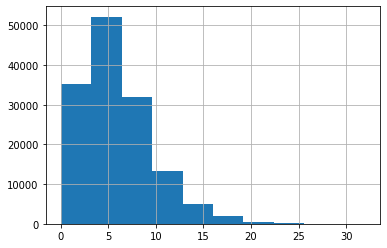

In [13]:
df['Contested Pos'].hist()

In [14]:
df.columns

Index(['Date', 'Name', 'Team', 'Season', 'Round', 'Home Team', 'Away Team',
       'Home Score', 'Away Score', 'Margin', 'Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists', 'Brownlow Votes',
       'TOG'],
      dtype='object')

In [15]:
# Contested Pos & BLV
contested_pos_blv = df[df['Contested Pos'] >= 5].groupby('Season')['Brownlow Votes'].mean().reset_index()
contested_pos_blv.columns = ['Season', '5+Contested_pos']

for i in range(10,21,5):
    col_name = str(i)+'+Contested_pos'
    contested_pos_blv[col_name] = df[df['Contested Pos'] >= i].groupby('Season')['Brownlow Votes'].mean().values
contested_pos_blv

,Season,5+Contested_pos,10+Contested_pos,15+Contested_pos,20+Contested_pos
0,2003.0,0.224448,0.546296,0.947761,1.181818
1,2004.0,0.228660,0.554348,0.976744,1.600000
2,2005.0,0.234341,0.597841,1.014085,1.800000
3,2006.0,0.229409,0.556222,1.038462,2.000000
4,2007.0,0.221886,0.539528,1.218750,0.666667
5,2008.0,0.227602,0.632944,1.325000,1.600000
6,2009.0,0.206208,0.523536,1.030303,2.000000
7,2010.0,0.201445,0.561151,1.160256,1.666667
8,2011.0,0.194766,0.496134,1.035971,1.861111
9,2012.0,0.196552,0.499370,1.069307,1.888889


When a player has 15+ contested possession, he is likely to secure a Brownlow vote. It is worth noting the importance of contested possession has decreased.

## 1.5 Uncontested possession <a id="15"></a>

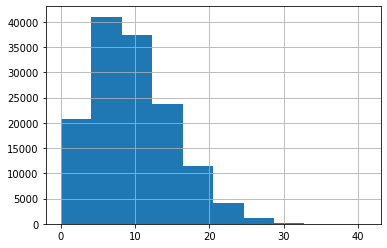

In [16]:
df['Uncontested Pos'].hist()

In [17]:
# Contested Pos & BLV
uncontested_pos_blv = df[df['Uncontested Pos'] >= 5].groupby('Season')['Brownlow Votes'].mean().reset_index()
uncontested_pos_blv.columns = ['Season', '5+Uncontested Pos']

for i in range(10,30,5):
    col_name = str(i)+'+Uncontested Pos'
    uncontested_pos_blv[col_name] = df[df['Uncontested Pos'] >= i].groupby('Season')['Brownlow Votes'].mean().values
uncontested_pos_blv

,Season,5+Uncontested Pos,10+Uncontested Pos,15+Uncontested Pos,20+Uncontested Pos,25+Uncontested Pos
0,2003.0,0.181577,0.323732,0.559201,0.962406,1.545455
1,2004.0,0.180672,0.326713,0.617050,1.088889,1.666667
2,2005.0,0.169064,0.280181,0.454717,0.810680,0.869565
3,2006.0,0.156100,0.225142,0.370439,0.549199,0.658228
4,2007.0,0.157388,0.227763,0.370525,0.618290,0.968750
5,2008.0,0.148721,0.202547,0.333151,0.557252,0.771429
6,2009.0,0.150236,0.210574,0.336634,0.608992,0.919753
7,2010.0,0.149336,0.216590,0.379310,0.671315,0.914894
8,2011.0,0.156754,0.241433,0.420369,0.786517,1.254237
9,2012.0,0.157273,0.250427,0.444010,0.868895,1.333333


A player with 25+ Uncontested possession is likely to secure a Brownlow vote. There isn't a trend in the importance of uncontested possession.

## 1.6 Home court advantage <a id="16"></a>
Home court advantage refers to  the benefit that the home team is said to gain over the visiting team. This benefit has been attributed to psychological effects supporting fans have on the competitors or referees. Let's examine whether the home team player is more likely to receive Brwonlow votes.

In [18]:
# boolean indicator for home team
df['Home_court'] = df['Team'] == df['Home Team']

In [19]:
# home team average Brownlow votes
df[df['Home_court'] == True]['Brownlow Votes'].mean()

0.15235643281127084

In [20]:
# away team average Brownlow votes
df[df['Home_court'] == False]['Brownlow Votes'].mean()

0.11805595285771497

Home court advantage seems to present.

# 2. Feature Engineering <a id="20"></a>
## 2.1 Time block number <a id="21"></a>
Since this task is essentially a time series forecast problem, adding a time block number will facilitate the feature generation process. The time block number of round 1 2003 is 1 and will increment by 1 for each round.

In [21]:
# match time block number with season round
temp = df.groupby(['Season', 'Round'])['Name'].count().reset_index().drop(['Name'], axis = 1).sort_values(by = ['Season', 'Round'])
temp['time_block_number'] = [i for i in range(len(temp))]
temp

,Season,Round,time_block_number
0,2003.0,1,0
1,2003.0,2,1
2,2003.0,3,2
3,2003.0,4,3
4,2003.0,5,4
...,...,...,...
379,2019.0,19,379
380,2019.0,20,380
381,2019.0,21,381
382,2019.0,22,382


In [22]:
# merge with original df
df = pd.merge(df, temp, on = ['Season', 'Round'])

## 2.2 Match ID <a id="22"></a>
Adding a match ID will facilitae the process of aggregating data for a particular match.

In [23]:
temp = df.groupby(['Season','Round','Home Team', 'Away Team'])['Name'].count().reset_index().sort_values(by=['Season','Round','Home Team']).drop(['Name'], axis = 1)
temp['match_id'] = [i for i in range(len(temp))]
temp

,Season,Round,Home Team,Away Team,match_id
0,2003.0,1,Adelaide,Fremantle,0
1,2003.0,1,Brisbane Lions,Essendon,1
2,2003.0,1,Collingwood,Richmond,2
3,2003.0,1,Melbourne,Hawthorn,3
4,2003.0,1,North Melbourne,St Kilda,4
...,...,...,...,...,...
3173,2019.0,23,Port Adelaide,Fremantle,3173
3174,2019.0,23,Richmond,Brisbane Lions,3174
3175,2019.0,23,Sydney,St Kilda,3175
3176,2019.0,23,West Coast,Hawthorn,3176


In [24]:
df = pd.merge(df, temp, on = ['Season', 'Round', 'Home Team', 'Away Team'])
df

,Date,Name,Team,Season,Round,Home Team,Away Team,Home Score,Away Score,Margin,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,Brownlow Votes,TOG,Home_court,time_block_number,match_id
0,2019-08-25 00:00:00,Michael Walters,Fremantle,2019.0,23,Port Adelaide,Fremantle,110,67,43,19.0,9.0,3.0,10.0,3.0,1.0,0.0,2.0,0.0,3.0,1.0,3.0,1.0,1.0,7.0,12.0,0.0,3.0,3.0,0.0,0.0,88,False,383,3173
1,2019-08-25 00:00:00,Darcy Tucker,Fremantle,2019.0,23,Port Adelaide,Fremantle,110,67,43,16.0,10.0,3.0,6.0,0.0,2.0,0.0,3.0,3.0,1.0,2.0,3.0,0.0,1.0,6.0,10.0,0.0,1.0,0.0,0.0,0.0,75,False,383,3173
2,2019-08-25 00:00:00,Sam Switkowski,Fremantle,2019.0,23,Port Adelaide,Fremantle,110,67,43,12.0,3.0,0.0,9.0,1.0,1.0,0.0,4.0,0.0,0.0,2.0,4.0,3.0,0.0,10.0,2.0,0.0,0.0,1.0,1.0,0.0,73,False,383,3173
3,2019-08-25 00:00:00,Ryan Nyhuis,Fremantle,2019.0,23,Port Adelaide,Fremantle,110,67,43,6.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,4.0,0.0,0.0,2.0,0.0,0.0,79,False,383,3173
4,2019-08-25 00:00:00,David Mundy,Fremantle,2019.0,23,Port Adelaide,Fremantle,110,67,43,19.0,7.0,2.0,12.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,3.0,0.0,0.0,11.0,10.0,0.0,2.0,3.0,1.0,0.0,83,False,383,3173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139826,2005-08-06 00:00:00,Michael Doughty,Adelaide,2005.0,19,Adelaide,Melbourne,100,46,54,7.0,3.0,2.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,73,True,62,496
139827,2005-08-06 00:00:00,Brett Burton,Adelaide,2005.0,19,Adelaide,Melbourne,100,46,54,17.0,15.0,4.0,2.0,0.0,0.0,1.0,3.0,2.0,5.0,2.0,3.0,3.0,2.0,7.0,12.0,0.0,0.0,3.0,0.0,0.0,89,True,62,496
139828,2005-08-06 00:00:00,Nathan Bock,Adelaide,2005.0,19,Adelaide,Melbourne,100,46,54,14.0,12.0,4.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,3.0,0.0,3.0,2.0,13.0,0.0,0.0,6.0,0.0,0.0,100,True,62,496
139829,2005-08-06 00:00:00,Rhett Biglands,Adelaide,2005.0,19,Adelaide,Melbourne,100,46,54,11.0,4.0,1.0,7.0,1.0,0.0,19.0,2.0,1.0,4.0,3.0,0.0,2.0,0.0,6.0,5.0,1.0,0.0,1.0,1.0,0.0,51,True,62,496


## 2.3 Ratios of statistics <a id="23"></a>
A better way to look at player statistics is to compare the statistics to everyone else in the same match. Scoring 10 goals is certainly impressive for a player, however if a player in the opponent team scores 20 goals, the first player is unlikely to attract Brownlow votes.

In [25]:
df.columns

Index(['Date', 'Name', 'Team', 'Season', 'Round', 'Home Team', 'Away Team',
       'Home Score', 'Away Score', 'Margin', 'Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists', 'Brownlow Votes',
       'TOG', 'Home_court', 'time_block_number', 'match_id'],
      dtype='object')

In [26]:
# statistics to calculate ratios
ratio_cols = ['Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'Hitouts',\
             'Tackles','Rebounds','Inside 50s', 'Clearances', 'Clangers', 'Frees For', \
             'Frees Against', 'Contested Pos', 'Uncontested Pos','Contested Marks',\
             'Marks Inside 50', 'One Percenters', 'Goal Assists']
# calculate player statistic ratio for each match
ratio_df = df.loc[:, ['match_id'] + ratio_cols].groupby('match_id').transform(lambda x: x/ x.sum())

In [27]:
ratio_df

,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists
0,0.025641,0.021739,0.017341,0.030581,0.12,0.04,0.000000,0.017699,0.000000,0.033708,0.014925,0.026549,0.027778,0.027778,0.024735,0.026374,0.000000,0.083333,0.030928,0.000000
1,0.021592,0.024155,0.017341,0.018349,0.00,0.08,0.000000,0.026549,0.047619,0.011236,0.029851,0.026549,0.000000,0.027778,0.021201,0.021978,0.000000,0.027778,0.000000,0.000000
2,0.016194,0.007246,0.000000,0.027523,0.04,0.04,0.000000,0.035398,0.000000,0.000000,0.029851,0.035398,0.083333,0.000000,0.035336,0.004396,0.000000,0.000000,0.010309,0.052632
3,0.008097,0.009662,0.011561,0.006116,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.014925,0.017699,0.027778,0.027778,0.007067,0.008791,0.000000,0.000000,0.020619,0.000000
4,0.025641,0.016908,0.011561,0.036697,0.04,0.04,0.000000,0.008850,0.015873,0.022472,0.029851,0.026549,0.000000,0.000000,0.038869,0.021978,0.000000,0.055556,0.030928,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139826,0.011706,0.008242,0.012821,0.017094,0.00,0.00,0.000000,0.047170,0.000000,0.000000,0.013699,0.021277,0.000000,0.044444,0.008163,0.014205,0.000000,0.000000,0.000000,0.000000
139827,0.028428,0.041209,0.025641,0.008547,0.00,0.00,0.012987,0.028302,0.025974,0.049020,0.027397,0.031915,0.066667,0.044444,0.028571,0.034091,0.000000,0.000000,0.037037,0.000000
139828,0.023411,0.032967,0.025641,0.008547,0.00,0.00,0.012987,0.018868,0.025974,0.019608,0.000000,0.031915,0.000000,0.066667,0.008163,0.036932,0.000000,0.000000,0.074074,0.000000
139829,0.018395,0.010989,0.006410,0.029915,0.05,0.00,0.246753,0.018868,0.012987,0.039216,0.041096,0.000000,0.044444,0.000000,0.024490,0.014205,0.066667,0.000000,0.012346,0.100000


In [28]:
# column from original df
feature_cols = ['Date','Name','Team','Season','Round','time_block_number','match_id','Home Score', 'Away Score', 'Margin', 'Home_court','Brownlow Votes']
# join with ratio df
feature_df = df[feature_cols].copy().join(ratio_df)

## 2.4 Scorer feature <a id="24"></a>
A boolean to indicate whether a player score 5+ goals

In [29]:
feature_df['scorer'] = df['Goals'].apply(lambda x: 1 if x>=5 else 0)

## 2.5 Passer feature <a id="25"></a>
A boolean to indicate whether a player has 30+ disposals

In [30]:
feature_df['passer'] = df['Disposals'].apply(lambda x: 1 if x>=30 else 0)

## 2.6 Contested_pos feature <a id="26"></a>

A boolean indicate whether a player has 15+ contested pos

In [31]:
feature_df['con_pos'] = df['Contested Pos'].apply(lambda x: 1 if x>=15 else 0)

## 2.7 Uncontesed_pos feature <a id="27"></a>
A boolean indicate whether a player has 25+ uncontested pos

In [32]:
feature_df['uncon_pos'] = df['Uncontested Pos'].apply(lambda x: 1 if x>=25 else 0)

## 2.8 Past Season Brownlow Votes <a id="28"></a>
For time series problem, past performance generally has predictive power. Since Brownlow votes are voted by umpire, they might have bias towards candidates who have good performance in the past.

I will calculate the total and average Brownlow Votes.

In [33]:
# calculate previous season BLV total and average
temp = feature_df.groupby(['Name', 'Season']).agg({'Brownlow Votes':[np.sum, np.mean] }).reset_index()
temp['match season'] = temp['Season']+1
temp.columns = temp.columns.get_level_values(0)
temp.columns = ['Name', 'Season', 'Prev Season BLV total', 'Prev Season BLV average', 'match season']
temp = temp[['Name', 'match season', 'Prev Season BLV total', 'Prev Season BLV average']]
temp

,Name,match season,Prev Season BLV total,Prev Season BLV average
0,Aaron Black,2012.0,0.0,0.000000
1,Aaron Black,2013.0,0.0,0.000000
2,Aaron Black,2014.0,0.0,0.000000
3,Aaron Black,2015.0,0.0,0.000000
4,Aaron Black,2016.0,0.0,0.000000
...,...,...,...,...
10413,Zak Jones,2018.0,2.0,0.095238
10414,Zak Jones,2019.0,0.0,0.000000
10415,Zak Jones,2020.0,0.0,0.000000
10416,Zephaniah Skinner,2012.0,0.0,0.000000


In [34]:
# merge temp with featrue df
feature_df = pd.merge(feature_df, temp, left_on = ['Name', 'Season'], right_on = ['Name','match season'], how = 'left').fillna(0)
del feature_df['match season']

In [35]:
feature_df.to_hdf('feature_temp.h5', 'feature_temp')

## 2.9 Lag features <a id="29"></a>
Past match performance normally has predictive power of current match performance. Therefore it is worthwhile generating lag features for the statistics. The most recent match performance could serve as an indicator of a player's form. I decide to also include the average of the most recent 5 lags to account for the fact that player's performance could be erratic and they could face very strong/weak enemies in the past match. Taking the average would balance out the outliers effect.

In [36]:
# sort df since not in chronological order
feature_df = feature_df.sort_values(by = ['time_block_number', 'Team'])

In [37]:
feature_df.columns

Index(['Date', 'Name', 'Team', 'Season', 'Round', 'time_block_number',
       'match_id', 'Home Score', 'Away Score', 'Margin', 'Home_court',
       'Brownlow Votes', 'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals',
       'Behinds', 'Hitouts', 'Tackles', 'Rebounds', 'Inside 50s', 'Clearances',
       'Clangers', 'Frees For', 'Frees Against', 'Contested Pos',
       'Uncontested Pos', 'Contested Marks', 'Marks Inside 50',
       'One Percenters', 'Goal Assists', 'scorer', 'passer', 'con_pos',
       'uncon_pos', 'Prev Season BLV total', 'Prev Season BLV average'],
      dtype='object')

In [38]:
# stats to calculate lag features
shift_col = ['Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals',
       'Behinds', 'Hitouts', 'Tackles', 'Rebounds', 'Inside 50s', 'Clearances',
       'Clangers', 'Frees For', 'Frees Against', 'Contested Pos',
       'Uncontested Pos', 'Contested Marks', 'Marks Inside 50',
       'One Percenters', 'Goal Assists', 'scorer', 'passer', 'con_pos',
       'uncon_pos','Brownlow Votes']

# lag1 to 5 df
lag1 = feature_df.groupby(['Name'])[shift_col].shift(1)
lag2 = feature_df.groupby(['Name'])[shift_col].shift(2)
lag3 = feature_df.groupby(['Name'])[shift_col].shift(3)
lag4 = feature_df.groupby(['Name'])[shift_col].shift(4)
lag5 = feature_df.groupby(['Name'])[shift_col].shift(5)
# calculate mean
lag1_5 = pd.DataFrame(np.nanmean([lag1, lag2, lag3, lag4, lag5], axis = 0))
# rename columns
lag1_5.columns = [i+'_lag1_5' for i in shift_col]
lag1.columns = [i+'_lag1' for i in shift_col]

C:\Users\joete\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [39]:
# concat lag1 and lag1_5 together
lags = pd.concat([lag1.reset_index().drop('index', axis = 1), lag1_5],axis = 1)

In [40]:
feature_df = feature_df.reset_index().drop(['index'], axis = 1)
# concat feature df with lags
feature_df = pd.concat([feature_df, lags], axis =1)

In [41]:
feature_df

,Date,Name,Team,Season,Round,time_block_number,match_id,Home Score,Away Score,Margin,Home_court,Brownlow Votes,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,scorer,passer,con_pos,uncon_pos,Prev Season BLV total,Prev Season BLV average,Disposals_lag1,Kicks_lag1,Marks_lag1,Handballs_lag1,Goals_lag1,Behinds_lag1,Hitouts_lag1,Tackles_lag1,Rebounds_lag1,Inside 50s_lag1,Clearances_lag1,Clangers_lag1,Frees For_lag1,Frees Against_lag1,Contested Pos_lag1,Uncontested Pos_lag1,Contested Marks_lag1,Marks Inside 50_lag1,One Percenters_lag1,Goal Assists_lag1,scorer_lag1,passer_lag1,con_pos_lag1,uncon_pos_lag1,Brownlow Votes_lag1,Disposals_lag1_5,Kicks_lag1_5,Marks_lag1_5,Handballs_lag1_5,Goals_lag1_5,Behinds_lag1_5,Hitouts_lag1_5,Tackles_lag1_5,Rebounds_lag1_5,Inside 50s_lag1_5,Clearances_lag1_5,Clangers_lag1_5,Frees For_lag1_5,Frees Against_lag1_5,Contested Pos_lag1_5,Uncontested Pos_lag1_5,Contested Marks_lag1_5,Marks Inside 50_lag1_5,One Percenters_lag1_5,Goal Assists_lag1_5,scorer_lag1_5,passer_lag1_5,con_pos_lag1_5,uncon_pos_lag1_5,Brownlow Votes_lag1_5
0,2003-03-30 00:00:00,Jason Torney,Adelaide,2003.0,1,0,0,145,89,56,True,2.0,0.047458,0.031792,0.041379,0.069672,0.028571,0.052632,0.00000,0.010870,0.017544,0.028846,0.060606,0.013889,0.000000,0.000000,0.050388,0.049708,0.045455,0.000000,0.029851,0.047619,0,0,0,0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-03-30 00:00:00,Mark Stevens,Adelaide,2003.0,1,0,0,145,89,56,True,0.0,0.035593,0.031792,0.034483,0.040984,0.085714,0.157895,0.00000,0.010870,0.000000,0.028846,0.000000,0.013889,0.054054,0.000000,0.034884,0.035088,0.000000,0.093750,0.014925,0.047619,0,0,0,0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-03-30 00:00:00,Tyson Stenglein,Adelaide,2003.0,1,0,0,145,89,56,True,0.0,0.013559,0.005780,0.013793,0.024590,0.000000,0.000000,0.00000,0.043478,0.000000,0.009615,0.015152,0.000000,0.027027,0.000000,0.015504,0.014620,0.000000,0.000000,0.029851,0.000000,0,0,0,0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-03-30 00:00:00,Nigel Smart,Adelaide,2003.0,1,0,0,145,89,56,True,0.0,0.025424,0.020231,0.034483,0.032787,0.000000,0.052632,0.00000,0.000000,0.000000,0.048077,0.030303,0.027778,0.027027,0.000000,0.019380,0.029240,0.000000,0.031250,0.014925,0.047619,0,0,0,0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-03-30 00:00:00,Mark Ricciuto,Adelaide,2003.0,1,0,0,145,89,56,True,0.0,0.047458,0.037572,0.020690,0.061475,0.000000,0.052632,0.00000,0.032609,0.017544,0.009615,0.075758,0.041667,0.027027,0.026316,0.038760,0.052632,0.000000,0.000000,0.029851,0.000000,0,0,0,0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139826,2019-08-25 00:00:00,Jos

## 2.10 Team performance <a id="210"></a>
Winning percentage of team in the past 5 games. The rationale of creating such feature is, a strong player in a strong team is more likely to be voted than a strong player in a weak team. This is because strong team usually receive more media coverage and this could introduce bias to the umpire.

In [42]:
# home win indicator
df['Home win'] = df['Home Score'] > df['Away Score']
# home win and away win
df['win'] = ((df['Home win'] == True) & (df['Team'] == df['Home Team']))|((df['Home win'] == False) & (df['Team'] == df['Away Team']))

In [43]:
# aggreagate to show result
team_result = df.groupby(['Team','Season','Round']).agg({'win':'min'}).reset_index()
team_result.tail()

,Team,Season,Round,win
6351,Western Bulldogs,2019.0,19,True
6352,Western Bulldogs,2019.0,20,False
6353,Western Bulldogs,2019.0,21,True
6354,Western Bulldogs,2019.0,22,True
6355,Western Bulldogs,2019.0,23,True


In [44]:
# calculate lags
team_result['win_lag1'] = team_result.groupby('Team')['win'].shift(1)
team_result['win_lag2'] = team_result.groupby('Team')['win'].shift(2)
team_result['win_lag3'] = team_result.groupby('Team')['win'].shift(3)
team_result['win_lag4'] = team_result.groupby('Team')['win'].shift(4)
team_result['win_lag5'] = team_result.groupby('Team')['win'].shift(5)
# calculate mean
team_result['win_lag1_5']= team_result.iloc[:,4:].mean(skipna = True, axis = 1)
team_result.tail()

,Team,Season,Round,win,win_lag1,win_lag2,win_lag3,win_lag4,win_lag5,win_lag1_5
6351,Western Bulldogs,2019.0,19,True,False,True,True,True,False,0.6
6352,Western Bulldogs,2019.0,20,False,True,False,True,True,True,0.8
6353,Western Bulldogs,2019.0,21,True,False,True,False,True,True,0.6
6354,Western Bulldogs,2019.0,22,True,True,False,True,False,True,0.6
6355,Western Bulldogs,2019.0,23,True,True,True,False,True,False,0.6


In [45]:
# filter unnecessary columns
team_result = team_result[['Team', 'Season', 'Round', 'win_lag1_5']]
# join with feature df
feature_df = pd.merge(feature_df, team_result, on = ['Team', 'Season','Round'])

In [46]:
feature_df.tail()

,Date,Name,Team,Season,Round,time_block_number,match_id,Home Score,Away Score,Margin,Home_court,Brownlow Votes,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,scorer,passer,con_pos,uncon_pos,Prev Season BLV total,Prev Season BLV average,Disposals_lag1,Kicks_lag1,Marks_lag1,Handballs_lag1,Goals_lag1,Behinds_lag1,Hitouts_lag1,Tackles_lag1,Rebounds_lag1,Inside 50s_lag1,Clearances_lag1,Clangers_lag1,Frees For_lag1,Frees Against_lag1,Contested Pos_lag1,Uncontested Pos_lag1,Contested Marks_lag1,Marks Inside 50_lag1,One Percenters_lag1,Goal Assists_lag1,scorer_lag1,passer_lag1,con_pos_lag1,uncon_pos_lag1,Brownlow Votes_lag1,Disposals_lag1_5,Kicks_lag1_5,Marks_lag1_5,Handballs_lag1_5,Goals_lag1_5,Behinds_lag1_5,Hitouts_lag1_5,Tackles_lag1_5,Rebounds_lag1_5,Inside 50s_lag1_5,Clearances_lag1_5,Clangers_lag1_5,Frees For_lag1_5,Frees Against_lag1_5,Contested Pos_lag1_5,Uncontested Pos_lag1_5,Contested Marks_lag1_5,Marks Inside 50_lag1_5,One Percenters_lag1_5,Goal Assists_lag1_5,scorer_lag1_5,passer_lag1_5,con_pos_lag1_5,uncon_pos_lag1_5,Brownlow Votes_lag1_5,win_lag1_5
139826,2019-08-25 00:00:00,Josh Dunkley,Western Bulldogs,2019.0,23,383,3177,121,87,34,True,0.0,0.039759,0.029279,0.022857,0.051813,0.000000,0.000000,0.01087,0.023438,0.013158,0.028037,0.114943,0.021978,0.103448,0.000000,0.043333,0.038462,0.000000,0.000000,0.010309,0.00,0,1,0,0,4.0,0.210526,0.041499,0.039171,0.037037,0.044728,0.071429,0.000000,0.000000,0.072464,0.000000,0.039216,0.095238,0.010870,0.045455,0.000000,0.046429,0.040449,0.00,0.000000,0.053763,0.047619,0.0,1.0,0.0,0.0,2.0,0.044140,0.032887,0.018772,0.060964,0.022286,0.012500,0.008955,0.043575,0.014769,0.045365,0.087113,0.030507,0.051088,0.032434,0.056382,0.036220,0.000000,0.017934,0.028909,0.020050,0.0,0.8,0.6,0.0,1.0,0.6
139827,2019-08-25 00:00:00,Bailey Dale,Western Bulldogs,2019.0,23,383,3177,121,87,34,True,1.0,0.020482,0.024775,0.034286,0.015544,0.161290,0.176471,0.00000,0.007812,0.000000,0.000000,0.000000,0.043956,0.034483,0.034483,0.020000,0.023077,0.035714,0.193548,0.020619,0.00,1,0,0,0,0.0,0.000000,0.013387,0.020737,0.030864,0.003195,0.071429,0.055556,0.000000,0.028986,0.000000,0.039216,0.000000,0.065217,0.000000,0.000000,0.003571,0.017978,0.00,0.125000,0.021505,0.047619,0.0,0.0,0.0,0.0,0.0,0.017604,0.020255,0.024463,0.013766,0.110544,0.059829,0.000000,0.022492,0.000000,0.031319,0.000000,0.018677,0.012605,0.012137,0.014485,0.019075,0.006452,0.104727,0.004301,0.029716,0.2,0.0,0.0,0.0,0.2,0.6
139828,2019-08-25 00:00:00,Hayden Crozier,Western Bulldogs,2019.0,23,383,3177,121,87,34,True,0.0,0.024096,0.024775,0.040000,0.023316,0.000000,0.000000,0.00000,0.007812,0.065789,0.018692,0.000000,0.000000,0.034483,0.000000,0.016667,0.028846,0.035714,0.000000,0.020619,0.00,0,0,0,0,0.0,0.000000,0.017403,0.029954,0.030864,0.000000,0.000000,0.000000,0.000000,0.007246,0.041096,0.029412,0.011905,0.010870,0.045455,0.000000,0.014286,0.017978,0.05,0.000000,0.032258,0.000000,0.0,0.0,0.0,0.0,0.0,0.024358,0.030571,0.036708,0.015366,0.000000,0.000000,0.000000,0.016498,0.049383,0.013766,0.002381,0.021678,0.029911,0.000000,0.014505,0.030279,0.023859,0.000000,0.037659,0.000000,0.0,0.0,0.0,0.0,0.0,0.6
139829,2019-08-25 00:00:00,Zaine Cordy,Western Bulldogs,2019.0,23,383,3177,121,87,34,True,0.0,0.010843,0.009009,0.005714,0.012953,0.000000,0.000000,0.00000,0.023438,0.013158,0.009346,0.000000,0.000000,0.000000,0.000000,0.010000,0.013462,0.000000,0.000000,0.103093,0.00,0,0,0,0,0.0,0.000000,0.009371,0.009217,0.012346,0.009585,0.000000,0.000000,0.000000,0.014493,0.013699,0.000000,0.000000,0.000000,0.000000,0.000000,0.014286,0.008989,0.00,0.000000,0.064516,0.000000,0.0,0.0,0.0,0.0,0.0,0.012026,0.011241,0.015895,0.013070,0.000000,0.007692,0.000000,0.015794,0.009988,0.003883,0.005970,0.017474,0.004762,0.026105,0.011877,0.012941,0.029670,0.009091,0.058696,0.010526,0.0,0.0,0.0,0.0,0.

# 3. Final clean up <a id="30"></a>
Since I used quite a few of lag features, the results of first few rounds in season 2003 are distorted since there are no lag values. Further I also used the previous season Brownlow vote as feature which does not exist for the 2003 season. Therefore, I decided to drop the 2003 season from the training dataset.

In [47]:
feature_df = feature_df[feature_df['Season'] != 2003]

In [48]:
# drop unncessary columns
feature_df = feature_df.drop(['Date', 'Round','time_block_number','Home Score', 'Away Score', 'Margin'], axis = 1)

In [49]:
# place the target variable to the end
col_list = list(feature_df.columns)
col_list.remove('Brownlow Votes')
col_list.append('Brownlow Votes')

In [50]:
feature_df = feature_df[col_list]
feature_df.tail()

,Name,Team,Season,match_id,Home_court,Disposals,Kicks,Marks,Handballs,Goals,Behinds,Hitouts,Tackles,Rebounds,Inside 50s,Clearances,Clangers,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,scorer,passer,con_pos,uncon_pos,Prev Season BLV total,Prev Season BLV average,Disposals_lag1,Kicks_lag1,Marks_lag1,Handballs_lag1,Goals_lag1,Behinds_lag1,Hitouts_lag1,Tackles_lag1,Rebounds_lag1,Inside 50s_lag1,Clearances_lag1,Clangers_lag1,Frees For_lag1,Frees Against_lag1,Contested Pos_lag1,Uncontested Pos_lag1,Contested Marks_lag1,Marks Inside 50_lag1,One Percenters_lag1,Goal Assists_lag1,scorer_lag1,passer_lag1,con_pos_lag1,uncon_pos_lag1,Brownlow Votes_lag1,Disposals_lag1_5,Kicks_lag1_5,Marks_lag1_5,Handballs_lag1_5,Goals_lag1_5,Behinds_lag1_5,Hitouts_lag1_5,Tackles_lag1_5,Rebounds_lag1_5,Inside 50s_lag1_5,Clearances_lag1_5,Clangers_lag1_5,Frees For_lag1_5,Frees Against_lag1_5,Contested Pos_lag1_5,Uncontested Pos_lag1_5,Contested Marks_lag1_5,Marks Inside 50_lag1_5,One Percenters_lag1_5,Goal Assists_lag1_5,scorer_lag1_5,passer_lag1_5,con_pos_lag1_5,uncon_pos_lag1_5,Brownlow Votes_lag1_5,win_lag1_5,Brownlow Votes
139826,Josh Dunkley,Western Bulldogs,2019.0,3177,True,0.039759,0.029279,0.022857,0.051813,0.000000,0.000000,0.01087,0.023438,0.013158,0.028037,0.114943,0.021978,0.103448,0.000000,0.043333,0.038462,0.000000,0.000000,0.010309,0.00,0,1,0,0,4.0,0.210526,0.041499,0.039171,0.037037,0.044728,0.071429,0.000000,0.000000,0.072464,0.000000,0.039216,0.095238,0.010870,0.045455,0.000000,0.046429,0.040449,0.00,0.000000,0.053763,0.047619,0.0,1.0,0.0,0.0,2.0,0.044140,0.032887,0.018772,0.060964,0.022286,0.012500,0.008955,0.043575,0.014769,0.045365,0.087113,0.030507,0.051088,0.032434,0.056382,0.036220,0.000000,0.017934,0.028909,0.020050,0.0,0.8,0.6,0.0,1.0,0.6,0.0
139827,Bailey Dale,Western Bulldogs,2019.0,3177,True,0.020482,0.024775,0.034286,0.015544,0.161290,0.176471,0.00000,0.007812,0.000000,0.000000,0.000000,0.043956,0.034483,0.034483,0.020000,0.023077,0.035714,0.193548,0.020619,0.00,1,0,0,0,0.0,0.000000,0.013387,0.020737,0.030864,0.003195,0.071429,0.055556,0.000000,0.028986,0.000000,0.039216,0.000000,0.065217,0.000000,0.000000,0.003571,0.017978,0.00,0.125000,0.021505,0.047619,0.0,0.0,0.0,0.0,0.0,0.017604,0.020255,0.024463,0.013766,0.110544,0.059829,0.000000,0.022492,0.000000,0.031319,0.000000,0.018677,0.012605,0.012137,0.014485,0.019075,0.006452,0.104727,0.004301,0.029716,0.2,0.0,0.0,0.0,0.2,0.6,1.0
139828,Hayden Crozier,Western Bulldogs,2019.0,3177,True,0.024096,0.024775,0.040000,0.023316,0.000000,0.000000,0.00000,0.007812,0.065789,0.018692,0.000000,0.000000,0.034483,0.000000,0.016667,0.028846,0.035714,0.000000,0.020619,0.00,0,0,0,0,0.0,0.000000,0.017403,0.029954,0.030864,0.000000,0.000000,0.000000,0.000000,0.007246,0.041096,0.029412,0.011905,0.010870,0.045455,0.000000,0.014286,0.017978,0.05,0.000000,0.032258,0.000000,0.0,0.0,0.0,0.0,0.0,0.024358,0.030571,0.036708,0.015366,0.000000,0.000000,0.000000,0.016498,0.049383,0.013766,0.002381,0.021678,0.029911,0.000000,0.014505,0.030279,0.023859,0.000000,0.037659,0.000000,0.0,0.0,0.0,0.0,0.0,0.6,0.0
139829,Zaine Cordy,Western Bulldogs,2019.0,3177,True,0.010843,0.009009,0.005714,0.012953,0.000000,0.000000,0.00000,0.023438,0.013158,0.009346,0.000000,0.000000,0.000000,0.000000,0.010000,0.013462,0.000000,0.000000,0.103093,0.00,0,0,0,0,0.0,0.000000,0.009371,0.009217,0.012346,0.009585,0.000000,0.000000,0.000000,0.014493,0.013699,0.000000,0.000000,0.000000,0.000000,0.000000,0.014286,0.008989,0.00,0.000000,0.064516,0.000000,0.0,0.0,0.0,0.0,0.0,0.012026,0.011241,0.015895,0.013070,0.000000,0.007692,0.000000,0.015794,0.009988,0.003883,0.005970,0.017474,0.004762,0.026105,0.011877,0.012941,0.029670,0.009091,0.058696,0.010526,0.0,0.0,0.0,0.0,0.0,0.6,0.0
139830,Marcus Bontempelli,Western Bulldogs,2019.0,3177,True,0.037349,0.027027,0.011429,0.049223,0.032258,0.058824,0.00000,0.078125,0.026316,0.056075,0.080460,0.032967,0.034483,0.034483,0.053333,0.0307

I used the data from 2004-2013 for training, 2014-2015 for validation and 2016-2019 for testing.

In [51]:
# fill null values
feature_df = feature_df.fillna(0)

In [52]:
from sklearn.preprocessing import LabelEncoder

# label encode categorical features
le = LabelEncoder()

# change to categorical features
cat_features = ['Home_court', 'scorer_lag1','passer_lag1', 'con_pos_lag1',\
               'uncon_pos_lag1', 'scorer_lag1_5', 'passer_lag1_5', 'con_pos_lag1_5',\
               'uncon_pos_lag1_5', 'scorer', 'passer','con_pos', 'uncon_pos' ]

for f in cat_features:
    feature_df[f] = le.fit_transform(feature_df[f])

In [53]:
# Train test split
Train = feature_df[feature_df.Season < 2014]
Val = feature_df[(feature_df.Season == 2014) |(feature_df.Season == 2015)]
Test = feature_df[feature_df.Season >= 2016]

In [54]:
# split into predictors and target variables
X_train = Train.iloc[:,4:-1]
y_train = Train.iloc[:,-1]

X_val = Val.iloc[:,4:-1]
y_val = Val.iloc[:,-1]

X_test = Test.iloc[:,4:-1]
y_test = Test.iloc[:,-1]

In [55]:
# identify categorical features
categorical_features_indices = []

for i in range(len(X_train.columns)):
    for f in cat_features:
        if f == X_train.columns[i]:
            categorical_features_indices.append(i)
        
categorical_features_indices

[0, 21, 22, 23, 24, 47, 48, 49, 50, 72, 73, 74, 75]

# 4. Modelling <a id="40"></a>

## 4.1 Baseline <a id="41"></a>
I decide to establish a benchmark by predicting all the Brownlow Votes for all players as 0. The evaluation metric used is Mean Absolute Error. For any model that perform worse than this benchmark, that means, the model not just fails to identify the players that receive the Brownlow votes, but also predict the players who did not receive any votes as receiving votes.

In [56]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, np.zeros(len(y_test),))

0.13171487603305784

## 4.2 Base model <a id="42"></a>
### 4.2.1 Gradient Boosted Decision Tree <a id="421"></a>

In [57]:
from catboost import CatBoostRegressor

xg_reg=CatBoostRegressor(iterations=3000, depth=7, learning_rate=0.005, loss_function='MAE')
xg_reg.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1362701	test: 0.1362439	best: 0.1362439 (0)	total: 137ms	remaining: 6m 50s
1:	learn: 0.1361789	test: 0.1360995	best: 0.1360995 (1)	total: 218ms	remaining: 5m 27s
2:	learn: 0.1361415	test: 0.1360526	best: 0.1360526 (2)	total: 299ms	remaining: 4m 59s
3:	learn: 0.1360830	test: 0.1359857	best: 0.1359857 (3)	total: 375ms	remaining: 4m 41s
4:	learn: 0.1360195	test: 0.1359022	best: 0.1359022 (4)	total: 456ms	remaining: 4m 32s
5:	learn: 0.1359685	test: 0.1358526	best: 0.1358526 (5)	total: 537ms	remaining: 4m 27s
6:	learn: 0.1358945	test: 0.1357509	best: 0.1357509 (6)	total: 615ms	remaining: 4m 23s
7:	learn: 0.1358044	test: 0.1356308	best: 0.1356308 (7)	total: 691ms	remaining: 4m 18s
8:	learn: 0.1357261	test: 0.1355141	best: 0.1355141 (8)	total: 774ms	remaining: 4m 17s
9:	learn: 0.1356375	test: 0.1353820	best: 0.1353820 (9)	total: 847ms	remaining: 4m 13s
10:	learn: 0.1355667	test: 0.1352940	best: 0.1352940 (10)	total: 924ms	remaining: 4m 11s
11:	learn: 0.1354843	test: 0.1351905	best

In [58]:
# test error
mean_absolute_error(y_test,xg_reg.predict(X_test))

0.10901449899961264

The predictions will be normalised at the end. Now I will build a few more base models and stack them together.

### 4.2.2 Neural Net <a id="422"></a>

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [68]:
nn_reg = Sequential()
nn_reg.add(Dense(78, input_dim=78, activation='relu'))
nn_reg.add(Dense(150,activation ='relu'))
nn_reg.add(Dropout(0.2))
nn_reg.add(Dense(1))
# Compile model
nn_reg.compile(loss='mean_absolute_error', optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', patience = 5,verbose=1)

nn_reg.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 100, batch_size = 8, callbacks=[es])

Epoch 1/100
9983/9983 [==============================] - 6s 575us/step - loss: 0.1435 - val_loss: 0.1315
Epoch 2/100
9983/9983 [==============================] - 6s 566us/step - loss: 0.1319 - val_loss: 0.1234
Epoch 3/100
9983/9983 [==============================] - 6s 574us/step - loss: 0.1263 - val_loss: 0.1223
Epoch 4/100
9983/9983 [==============================] - 6s 582us/step - loss: 0.1260 - val_loss: 0.1191
Epoch 5/100
9983/9983 [==============================] - 6s 580us/step - loss: 0.1231 - val_loss: 0.1183
Epoch 6/100
9983/9983 [==============================] - 6s 594us/step - loss: 0.1243 - val_loss: 0.1185
Epoch 7/100
9983/9983 [==============================] - 6s 587us/step - loss: 0.1248 - val_loss: 0.1208
Epoch 8/100
9983/9983 [==============================] - 6s 586us/step - loss: 0.1237 - val_loss: 0.1189
Epoch 9/100
9983/9983 [==============================] - 6s 588us/step - loss: 0.1244 - val_loss: 0.1175
Epoch 10/100
9983/9983 [==============================]

## 4.3 Ensembling <a id="43"></a>
I stacked the Gradient Boosted Tree with the Neural Network.

In [69]:
# train metafeatures
mf1 = xg_reg.predict(X_train)
mf2 = nn_reg.predict(X_train).reshape(1,-1)[0]

X_train_meta = pd.DataFrame({'mf1':mf1, 'mf2':mf2})
X_train_meta.head()

,mf1,mf2
0,1.544695e-07,0.000056
1,8.276626e-08,0.000056
2,1.711074e-07,0.000056
3,-1.062477e-07,0.000056
4,-3.579922e-03,0.000056


In [70]:
# validation metafeatures
mf1_val = xg_reg.predict(X_val)
mf2_val = nn_reg.predict(X_val).reshape(1,-1)[0]

X_val_meta = pd.DataFrame({'mf1':mf1_val, 'mf2':mf2_val})
X_val_meta.head()

,mf1,mf2
0,7.973888e-02,0.000056
1,4.181710e-07,0.000056
2,1.308368e-07,0.000056
3,2.214833e-07,0.000056
4,-8.998458e-06,0.000056


In [71]:
# test metafeatures
mf1_test = xg_reg.predict(X_test)
mf2_test = nn_reg.predict(X_test).reshape(1,-1)[0]

X_test_meta = pd.DataFrame({'mf1':mf1_test, 'mf2':mf2_test})
X_test_meta.head()

,mf1,mf2
0,-4.384945e-05,0.000056
1,3.764438e-09,0.000056
2,3.257276e-01,1.077473
3,9.945637e-08,0.000056
4,4.775875e-07,0.000056


In [72]:
xg_reg2 = CatBoostRegressor(iterations=3000, depth=7, learning_rate=0.005, loss_function='MAE')
xg_reg2.fit(X_train_meta, y_train,eval_set=(X_val_meta, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1361792	test: 0.1361565	best: 0.1361565 (0)	total: 26.8ms	remaining: 1m 20s
1:	learn: 0.1360095	test: 0.1359555	best: 0.1359555 (1)	total: 53ms	remaining: 1m 19s
2:	learn: 0.1358138	test: 0.1357347	best: 0.1357347 (2)	total: 79.5ms	remaining: 1m 19s
3:	learn: 0.1356182	test: 0.1355159	best: 0.1355159 (3)	total: 106ms	remaining: 1m 19s
4:	learn: 0.1354242	test: 0.1352930	best: 0.1352930 (4)	total: 133ms	remaining: 1m 19s
5:	learn: 0.1352134	test: 0.1350582	best: 0.1350582 (5)	total: 159ms	remaining: 1m 19s
6:	learn: 0.1350092	test: 0.1348340	best: 0.1348340 (6)	total: 186ms	remaining: 1m 19s
7:	learn: 0.1348226	test: 0.1346220	best: 0.1346220 (7)	total: 212ms	remaining: 1m 19s
8:	learn: 0.1346183	test: 0.1343847	best: 0.1343847 (8)	total: 238ms	remaining: 1m 19s
9:	learn: 0.1344168	test: 0.1341595	best: 0.1341595 (9)	total: 264ms	remaining: 1m 18s
10:	learn: 0.1342190	test: 0.1339328	best: 0.1339328 (10)	total: 289ms	remaining: 1m 18s
11:	learn: 0.1340342	test: 0.1337270	bes

In [73]:
# test error
mean_absolute_error(y_test,xg_reg2.predict(X_test_meta))

0.10611039953744088

Stacking the gradient boost tree together with  a neural network offers a 2% increase in performance in terms of MAE. A slight improvement.

# 5. Normalising prediction for test set and predict for Brownlow medal winner <a id="50"></a>
Since the predictions do not follow the rules of Brownlow Votes, I decide to make prediction for all the players for all matches in the test set. Then fore each match, I will pick the 3 highest score and set their Brownlow Votes to 3,2 and 1 respectively and all the others to 0.

In [76]:
Test['prediction'] = xg_reg2.predict(X_test_meta)

C:\Users\joete\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
print(Test.prediction.min())
print(Test.prediction.max())

-0.0011657994128357974
3.00214688142698


There are negative values for the prediction, this is problematic because it will cancel out with the positve values. I decided to clip all the prediction above 0.

In [82]:
Test['prediction'] = np.clip(xg_reg2.predict(X_test_meta),0, float('inf'))

C:\Users\joete\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
# MAE after clipping
mean_absolute_error(y_test,Test.prediction)

0.10610991011392555

In [89]:
winner = Test.groupby(['Name', 'Season'])[['Brownlow Votes', 'prediction']].sum().reset_index().sort_values(by = ['Season','prediction'], ascending = False)

In [104]:
for i in range(2016,2020):
    actual_winner = winner[winner['Season'] == i].sort_values(by = ['Brownlow Votes'], ascending = False).iloc[0,0]
    predicted_winner = winner[winner['Season'] == i].sort_values(by = ['prediction'], ascending = False).iloc[0,0]
    print('Season: ' + str(i) + '\n' + 'Actual winner: ' + actual_winner + '\n' + 'Predicted winner: ' + predicted_winner + '\n')

Season: 2016
Actual winner: Patrick Dangerfield
Predicted winner: Patrick Dangerfield

Season: 2017
Actual winner: Dustin Martin
Predicted winner: Dustin Martin

Season: 2018
Actual winner: Tom Mitchell
Predicted winner: Tom Mitchell

Season: 2019
Actual winner: Nat Fyfe
Predicted winner: Jack Macrae



# 6. Conclusion <a id="60"></a>

The MAE of the model is 0.1062 which is 20% better than the baseline (0.1317). In terms of predicting the winner of the Brownlow Medal, the model successfully predicted the winner for 2016-2018 season.